# 2D Ornstein Uhlenbeck Type System Instanton Calculation via MAM

In this notebook we will use the MAM method outlined in [1] to calculate an instanton in a 2D OU type model. We will compare this to the analytic solution as well as the numerically integrated Hamilton Equations.

- [1] Weinan, E., Ren, W. and Vanden-Eijnden, E., 2004. Minimum action method for the study of rare events. Communications on pure and applied mathematics, 57(5), pp.637-656.

In [1]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# MAM Algorithm
from mam import Mam_alg

# Problem Definition & Parameter Choices

Here we define the drift function of the 2D OU system and specify our parameter choices.

In [2]:
# Drift Function Definition

def a(t, phi, s):
    """Drift term"""
    gamma1, gamma2, r = s
    x, T = phi.T
    return np.array([- gamma1 * (x + T), -gamma2 * (T - x)]).T

In [3]:
# Parameter Specification

# OU Parameters
gamma1 = 0.5
gamma2 = 0.25
r = 0.1
s = [gamma1, gamma2, r]

# Covariance matrix
sigma1 = 0.001
sigma2 = 0.002
D = np.zeros((2, 2))
D[0, 0] = sigma1**2
D[1, 1] = sigma2**2
Dinv = la.inv(D)

# Time
t0 = 0
tF = 10
dt = 0.1
steps = int((tF-t0)/dt)
time = np.arange(t0, tF, dt)

## MAM Set up

Here we define the initial instanton path for the minimisation problem, specify bounds and create a MAM algorithm object.

In [4]:
# Instanton Initialisation

initial_point = [0.1, 0.1]
final_point = [0, 0]

inst_ic = np.linspace(initial_point, final_point, steps)

In [5]:
# 
# Example Bounds Grid - Useful should you want to specify your own bounds
# -------------------
# 

bnds = np.zeros((*inst_ic.shape, 2)) # indexed by Time, ndim, lower/upper

# t = 0 Constraint
bnds[0,...,0] = initial_point - 0.01 * np.ones(inst_ic.shape[1]) # Lower
bnds[0,...,1] = initial_point + 0.01 * np.ones(inst_ic.shape[1]) # Upper

# Bounds for t \in (dt, T-dt)
bnds[1:-1, ..., 0] = - 1
bnds[1:-1, ..., 1] = 1

# t = T Constraint
bnds[-1,...,0] = final_point - 0.01 * np.ones(inst_ic.shape[1])
bnds[-1,...,1] = final_point + 0.01 * np.ones(inst_ic.shape[1])

In [12]:
# Object creation

# ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # default bounds
ou_mam = Mam_alg(a, s, inst_ic, time, Dinv, bnds=bnds) # specify bounds 

## Running MAM Algorithm

We run the algorithm for 80000 iterations/until convergence.

In [13]:
# Running for an initial 30000 Steps
options={'maxls': 10, 'maxiter': 30000, 'maxfun': 30000} 

In [14]:
result = ou_mam.run(options)

b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'


In [15]:
# Running algorithm for a further 40000 steps
options={'maxls': 10, 'maxiter': 40000, 'maxfun': 40000}
result = ou_mam.run(options) 
print(f'Algorithm has made {ou_mam.nfev} function evaluations')

b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
Algorithm has made 20100 function evaluations


## Comparison with "Analytic Soltuion"

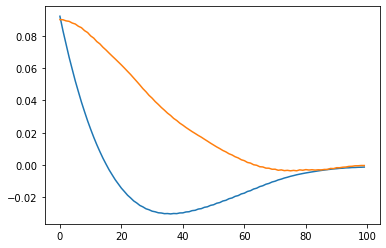

In [16]:
plt.plot(ou_mam.instanton)

In [11]:
### MAM CLASS DEFINITION



# import numpy as np
# from scipy.optimize import minimize
# # from scipy.integrate import trapezoid

# class Mam_alg:
#     """
#     Class for an convient run of the MAM algorithm. Built on scipy.minimise method.
    
#     - Object creation requires drift and initial path (see __init__).
#     - Once object is created, user should set bounds for optimisation problem via .bnds property.
#     - Use of .run(options) method then evolves .instanton property under MAM algorithm.
#     - .instanton property contains current state of minmisation.
    
#     Properties
#     -----------
#     instanton: np array
#         Current path being evolved by MAM, should converge to instanton. 
#         User shape is (time, ndim).
#         Class reshapes for scipy.minimise usage.
        
#     bnds: np array
#         Constraints for the minimisation problem.
#         Should be set before running. Object performs default initialisation.
#         User must set all bnds at the same time.
#         User provides shape of (T, ndim, 2).Indexed by: Time, ndim, lower/upper bound.
#         Class reshapes for scipy.minimise usage.
        
#     Methods
#     -----------
#     run(options)
#         Runs MAM algorithm until convergence or user specified limit.
    
#     Attributes
#     -----------
    
#     b_args: list 
#         Arguments used for drift b.
#         Note b is of form b(path, b_args)

#     ic: np array
#         Initial condition for minimisation problem. 
#         Shape is (time, ndim). 
#         Important that initial and final point specified.

#     time: np array
#         Time points that paths are parameterised along
#         Shape (T)

#     d: np array
#         Inverse of diffusion matrix. 
        
#     nfev: integer
#         Number of function evaluations in MAM thus far.

#     """
    
#     def __init__(self, b, b_args, ic, time, d, bnds=None):
#         """


#         Parameters
#         ----------
#         b: function 
#             Takes path and returns drift. 
#             Should be of form b(path, b_args).
#             Path input and are drift output are shape (time, ndim).
            
#         b_args: list 
#             Further arguments for b.
#             Note b is of form b(path, b_args)
    
#         ic: np array
#             Initial instanton path. 
#             Shape is (time, ndim). 
#             Important that initial and final point specified.
            
#         time: np array
#             Time points that paths are parameterised along
#             Shape (T)
            
#         d: np array
#             Inverse of diffusion matrix. 
#         """
        
#         # User Accessed attrbutes
#         self.time = time
#         self.d = d
#         self.b_args = b_args
#         self.ic = ic
#         self.nfev=0
        
#         # Internal attributes
#         self._b = b
#         self._user_shape = ic.shape
#         self._ic = ic.flatten()
#         self._instanton = ic.flatten() # Current state of minimisation

#         # Create default bounds, really user should set
#         if (bnds==None):
#             self._initialise_bnds() 
#             print("I've created default bounds, but you should probably set some.")
        
#     def _action(self, path):
#         """ Takes a path and computes the FW action along the path.

#         Path input is of form necesseary for scipy.minimise (see parameter explanation).
#         Finite differences are used to approximate derivatives.
#         Trapezoidal Rule used to compute integral

#         Parameters
#         ----------
#         path: np array
#             shape is flat (time * ndim) for use by scipy.minimise
#             method reshapes into (time, ndim)
#         """
#         h = path.reshape(self._user_shape)

#         # d_phi_dt calculation. Second time arg in np.gradient should be irrelevant.
#         v = self._b(0, h, self.b_args) - np.vstack(np.gradient(h, self.time.flatten(), 1)[0]) 

#         # Dot product calulcation
#         v2 = [] 
#         for x in v:
#             v2.append(x.dot(Dinv @ x.T))
#         return 0.5 * np.trapz(v2, x=time)
    
#     @property
#     def instanton(self):
#         "Current state of minimisation."
#         return self._instanton.reshape(self._user_shape)
    
#     @property
#     def bnds(self): # indexed by Time, ndim, lower/upper bound
#         "Bounds of optimisation problem"
#         return self._bnds.reshape((*self._user_shape, 2)) 
    
#     @bnds.setter 
#     def bnds(self, b): 
#         # reshapes for scipy.minimise usage
#         #b should be all of bounds when setting
#         self._bnds = b.reshape(len(self.ic.flatten()), 2)
    
#     def _initialise_bnds(self):
#         """ Initialises bounds for constraint, user is free to change.
#         The user specified bnds shape is different to the one used by underlying code.
#         """
        
#         # We initialise by creating an np array indexed by Time, ndim, lower/upper bound
#         # User specified bnds are of this form
#         self._bnds = np.zeros((*self._user_shape, 2))
#         initial_point = self.ic[0]
#         final_point = self.ic[-1]

#         # t = 0 Constraint
#         self._bnds[0,:,0] = initial_point - 0.01 * np.ones(self._user_shape[1]) # Lower bound
#         self._bnds[0,:,1] = initial_point + 0.01 * np.ones(self._user_shape[1]) # Upper bound

#         # Bounds for t \in (dt, T-dt)
#         self._bnds[1:-1, :, 0] = - 10 # 10 chosen as arbitrary default
#         self._bnds[1:-1, :, 1] = 10 # Important that this is changed for specific problem 

#         # t = T Constraint
#         self._bnds[-1,:,0] = final_point - 0.01 * np.ones(self._user_shape[1])
#         self._bnds[-1,:,1] = final_point + 0.01 * np.ones(self._user_shape[1])
        
#         # We then reshape to the form used by the object
#         self._bnds = self._bnds.reshape(len(self.ic.flatten()), 2)
        
#     def run(self, opt):
#         "Runs the MAM algorithm. opt feds scipy.minimize via options argument."
#         res = minimize(self._action, self._instanton, method='L-BFGS-B', bounds = self._bnds, 
#                options=opt)
#         print(res.message)
#         self._instanton = res.x
#         self.nfev += res.nfev
#         return 
        
        